In [3]:
# libraries

import pandas as pd # data frames
import numpy as np # numerical calculations
import matplotlib.pyplot as plt # to display error rate versus k value
from sklearn.model_selection import train_test_split # to split data into train and test
from sklearn.neighbors import KNeighborsClassifier # model for knn
from sklearn.metrics import classification_report,confusion_matrix # model results

In [4]:
# get engineered and scaled data from logistic regression project and display top 5 records 

# since KNN classifier predicts the class of a given test observation by identifying the observations 
# that are nearest to it, the scale of the variables matters 

modified_data_02_df = pd.read_csv('modified_data_02_df.csv') # read from user directory

modified_data_02_df.head(5)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age,Military,Nobility,Peerage,Religious,Untitled,Male,EmbrkQ,EmbrkS
0,0.000000,0.0,1.0,0.125,0.0,0.014151,0.271174,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.001124,1.0,0.0,0.125,0.0,0.139136,0.472229,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.002247,1.0,1.0,0.000,0.0,0.015469,0.321438,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.003371,1.0,0.0,0.125,0.0,0.103644,0.434531,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.004494,0.0,1.0,0.000,0.0,0.015713,0.434531,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [5]:
# drop features

modified_data_03_df = modified_data_02_df.drop(['Untitled'], axis=1)
modified_data_03_df.head(5)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age,Military,Nobility,Peerage,Religious,Male,EmbrkQ,EmbrkS
0,0.000000,0.0,1.0,0.125,0.0,0.014151,0.271174,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.001124,1.0,0.0,0.125,0.0,0.139136,0.472229,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002247,1.0,1.0,0.000,0.0,0.015469,0.321438,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.003371,1.0,0.0,0.125,0.0,0.103644,0.434531,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.004494,0.0,1.0,0.000,0.0,0.015713,0.434531,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [8]:
# function to choose a k value based on multiple trials
# returns a dataframe of results with mean used to display error versus k value

def k_value_trials(dataframe, target, trials, k_range):
    trials_list = []
     
    # generate error rates per k value    
    for ith_t in range(1,trials+1):  
        x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(target,axis=1), 
                                                            dataframe[target], test_size=0.30, 
                                                            random_state=ith_t)
        error_rate_list = []
        for ith_k in range(1,k_range+1):
            knn = KNeighborsClassifier(n_neighbors=ith_k)
            knn.fit(x_train,y_train)
            pred_i = knn.predict(x_test)
            error_rate_list.append(np.mean(pred_i != y_test))  

        trials_list.append(error_rate_list)
        
    # convert list of lists to dataframe, rename columns and insert mean
    trials_df_00 = pd.DataFrame(trials_list)
    trials_df_01 = trials_df_00.transpose()
    cols = trials_df_01.columns.values
    cols = cols + 1
    trials_df_01.columns = cols
    trials_df_01.insert(len(trials_df_01.columns.values), 'Mean', trials_df_01.mean(axis=1))
    
    return trials_df_01

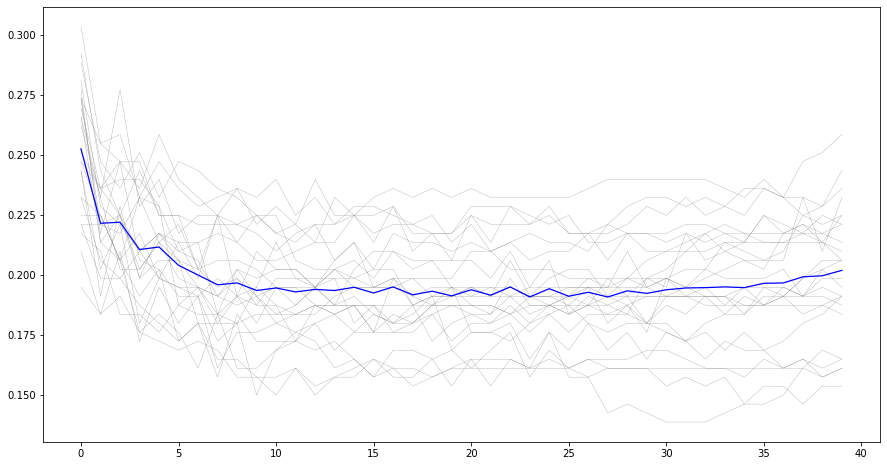

In [16]:
# display error rates versus k values and highlight the mean

trials_df_02 = k_value_trials(modified_data_03_df, 'Survived', 25, 40) 

plt.figure(figsize=(15,8))
plt.plot(trials_df_02.iloc[ 0:, 0:(len(trials_df_02.columns.values)-1) ], color='gray', lw=0.25)
plt.plot(trials_df_02.iloc[ 0:, len(trials_df_02.columns.values)-1 ], color='blue', lw=1.25)
plt.show()

In [13]:
# function to assess model performance

# note: default distance metric is minkowski, which is a generalization of both the Euclidean
# distance (used when all inputs have the same scale) and Manhattan distance (used when the
# scales of the input variables differ); using euclidean (since already scaled) did not improve accuracy 

def knn_mod_assess(dataframe, target, trials, k_value):
    
    knn_models_list = []
    
    # ith trial used as random state 
    for i in range(1,trials+1): 
        
        # split into train and test datasets
        x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(target,axis=1), 
                                                            dataframe[target], test_size=0.30, 
                                                            random_state=i)
        # make predictions
        knn = KNeighborsClassifier(n_neighbors=k_value)
        knn.fit(x_train,y_train)
        predictions = knn.predict(x_test)
        
        # create classification report, reformat column wise for each trial and append to a list
        report = classification_report(y_test, predictions, output_dict=True)
        class_rep_df = pd.DataFrame(report).reset_index().pivot(columns='index')
        class_rep_df.columns = class_rep_df.columns.to_series().str.join('_') # flatten and concatenate multilevel column
        class_rep_df.insert(0, 'GrpBy', '-')
        class_rep_df = class_rep_df.groupby('GrpBy').sum().reset_index()
        class_rep_df.drop('GrpBy',axis=1,inplace=True)
        class_rep_df.drop(class_rep_df.iloc[:, 9:],axis=1,inplace=True)
        class_rep_df.rename(columns={'accuracy_f1-score':'accuracy'}, inplace=True)
        class_rep_df.insert(9, 'k_value', k_value)
        class_rep_df.insert(10, 'Trials', trials)
        class_rep_df.insert(11, 'RandomState', i)
              
        # attach all data drames to a list 
        knn_models_list.append(class_rep_df)
        
    # convert list of dataframes to a single frame
    knn_models_all_df = pd.concat(knn_models_list, ignore_index=True)
    
    # change order of columns
    knn_models_all_df = knn_models_all_df[['0.0_precision', '0.0_recall', '0.0_f1-score', '0.0_support',  
                                           '1.0_precision', '1.0_recall', '1.0_f1-score', '1.0_support', 
                                           'accuracy', 'k_value', 'Trials', 'RandomState']] 
    # rename columns
    knn_models_all_df.rename(columns={ '0.0_precision':'0_precision', '0.0_recall':'0_recall', 
                                       '0.0_f1-score':'0_f1-score', '0.0_support':'0_support',
                                       '1.0_precision':'1_precision', '1.0_recall':'1_recall', 
                                       '1.0_f1-score':'1_f1-score', '1.0_support':'1_support',}, inplace = True)

    return knn_models_all_df.round(2)

In [14]:
# display summarized results
results_df = knn_mod_assess(modified_data_03_df, 'Survived', 25, 20)
results_avg_df = pd.DataFrame(results_df.iloc[ 0:, results_df.columns != 'RandomState'  ].mean()).transpose()
results_avg_df.round(2)

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy,k_value,Trials
0,0.79,0.93,0.86,165.0,0.85,0.61,0.71,102.0,0.81,20.0,25.0


In [15]:
# display all results
results_df = knn_mod_assess(modified_data_03_df, 'Survived', 25, 22)
results_df

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy,k_value,Trials,RandomState
0,0.82,0.95,0.88,166.0,0.88,0.65,0.75,101.0,0.84,22,25,1
1,0.83,0.95,0.89,170.0,0.89,0.66,0.76,97.0,0.85,22,25,2
2,0.73,0.96,0.83,158.0,0.89,0.50,0.64,109.0,0.77,22,25,3
3,0.80,0.95,0.87,164.0,0.88,0.62,0.73,103.0,0.82,22,25,4
4,0.84,0.92,0.88,172.0,0.82,0.67,0.74,95.0,0.83,22,25,5
5,0.78,0.94,0.86,162.0,0.88,0.60,0.71,105.0,0.81,22,25,6
6,0.77,0.94,0.84,160.0,0.86,0.57,0.69,107.0,0.79,22,25,7
7,0.80,0.92,0.85,166.0,0.82,0.62,0.71,101.0,0.81,22,25,8
8,0.79,0.95,0.86,161.0,0.89,0.61,0.73,106.0,0.82,22,25,9
9,0.79,0.95,0.86,169.0,0.86,0.56,0.68,98.0,0.81,22,25,10
